<a href="https://colab.research.google.com/github/akshatamadavi/cmpe258-assignment-3/blob/main/%5Bcolab_e1%5Dnonlinear_regression_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3-Layer DNN for Nonlinear Regression — TensorFlow: 4 Variants

All four variants fit the same data: `y = sin(2πx) + noise`

| Variant | Style |
|---|---|
| **1. Low-Level** | Manual weights, `GradientTape`, raw backprop |
| **2. Keras Sequential API** | `tf.keras.Sequential` + `model.fit` |
| **3. Keras Functional API** | `tf.keras.Input` → layer graph → `Model` |
| **4. Subclassed Model** | `tf.keras.Model` subclass (PyTorch-style) |

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.19.0


---
## Shared Data (used by all variants)

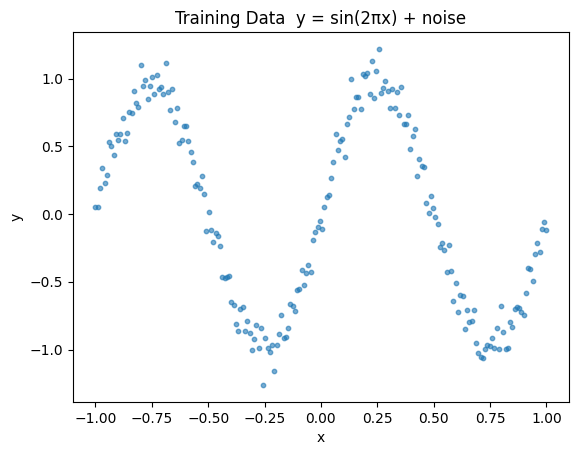

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

X = np.linspace(-1, 1, 200).astype(np.float32).reshape(-1, 1)
y = np.sin(2 * np.pi * X) + 0.1 * np.random.randn(*X.shape).astype(np.float32)

plt.scatter(X, y, s=10, alpha=0.6)
plt.title('Training Data  y = sin(2πx) + noise')
plt.xlabel('x'); plt.ylabel('y'); plt.show()

def plot_fit(X, y, y_pred, title):
    plt.scatter(X, y, s=10, alpha=0.4, label='Data')
    plt.plot(X, y_pred, color='red', linewidth=2, label='Prediction')
    plt.title(title); plt.xlabel('x'); plt.ylabel('y')
    plt.legend(); plt.show()

---
## Variant 1 — Low-Level TensorFlow
> Manually create weight matrices & biases as `tf.Variable`.  
> Use `tf.GradientTape` to compute gradients and update weights by hand.
> No Keras at all.

Epoch  400 | Loss: 0.476396
Epoch  800 | Loss: 0.471713
Epoch 1200 | Loss: 0.467184
Epoch 1600 | Loss: 0.462112
Epoch 2000 | Loss: 0.457440


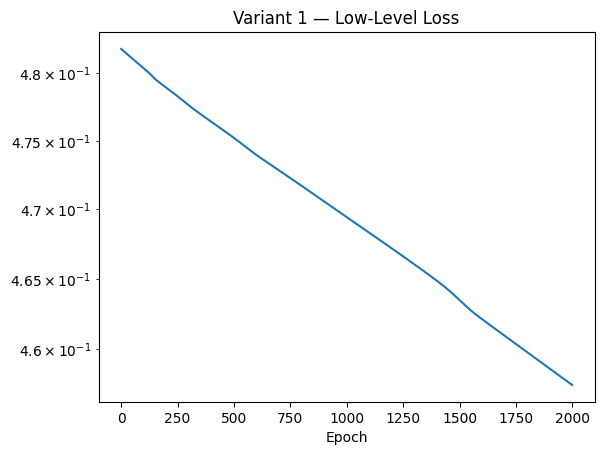

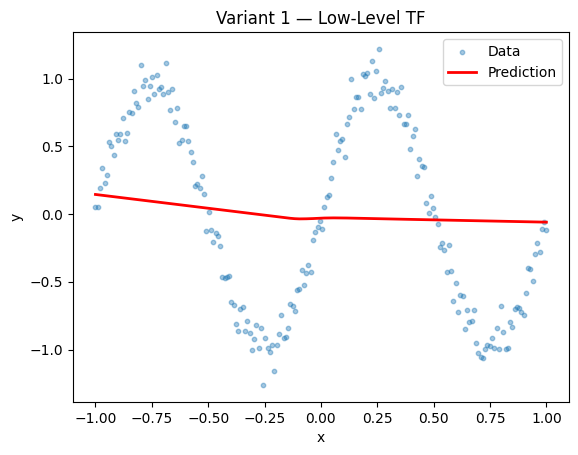

In [3]:
# ── Weight initialization ──────────────────────────────────────────────────
def make_weights(in_dim, out_dim):
    W = tf.Variable(tf.random.normal([in_dim, out_dim], stddev=0.1))
    b = tf.Variable(tf.zeros([out_dim]))
    return W, b

W1, b1 = make_weights(1,  64)
W2, b2 = make_weights(64, 64)
W3, b3 = make_weights(64, 1)

params = [W1, b1, W2, b2, W3, b3]

# ── Forward pass ──────────────────────────────────────────────────────────
def forward(x):
    h1 = tf.nn.relu(x  @ W1 + b1)   # layer 1
    h2 = tf.nn.relu(h1 @ W2 + b2)   # layer 2
    return          h2 @ W3 + b3    # layer 3 (linear output)

# ── Training loop with GradientTape ───────────────────────────────────────
lr     = 1e-3
losses = []

for epoch in range(2000):
    with tf.GradientTape() as tape:
        y_pred = forward(X)
        loss   = tf.reduce_mean(tf.square(y_pred - y))   # MSE

    grads = tape.gradient(loss, params)   # backprop

    # manual SGD-style update
    for param, grad in zip(params, grads):
        param.assign_sub(lr * grad)

    losses.append(loss.numpy())
    if (epoch + 1) % 400 == 0:
        print(f'Epoch {epoch+1:4d} | Loss: {loss.numpy():.6f}')

plt.plot(losses); plt.yscale('log')
plt.title('Variant 1 — Low-Level Loss'); plt.xlabel('Epoch'); plt.show()

plot_fit(X, y, forward(X).numpy(), 'Variant 1 — Low-Level TF')

---
## Variant 2 — Keras Sequential API
> Stack layers with `tf.keras.Sequential`.  
> Compile with loss + optimizer, then call `model.fit`.  
> The simplest and most concise approach.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

Final loss: 0.008152


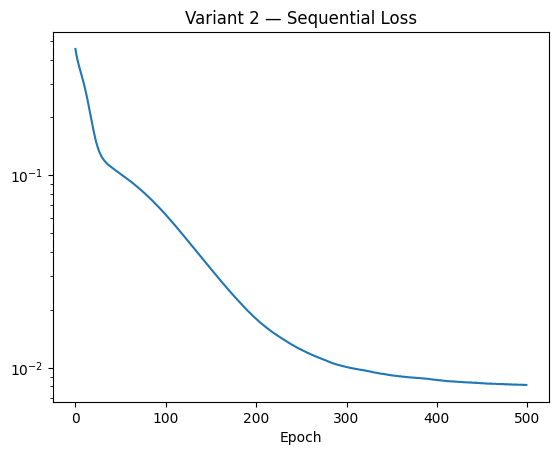

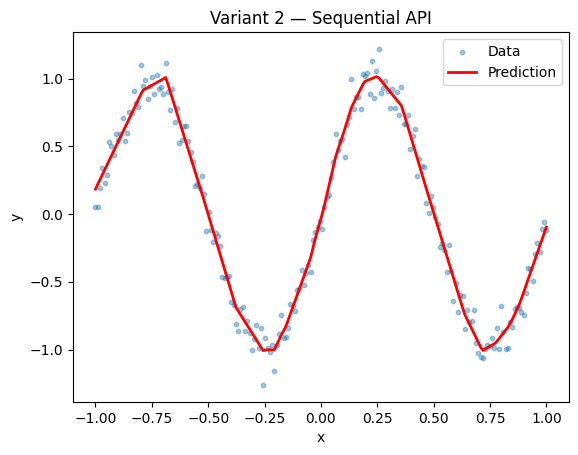

In [4]:
seq_model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(1,)),  # layer 1
    tf.keras.layers.Dense(64, activation='relu'),                    # layer 2
    tf.keras.layers.Dense(1)                                         # layer 3
], name='sequential_model')

seq_model.summary()

seq_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse'
)

history = seq_model.fit(X, y, epochs=500, batch_size=32, verbose=0)
print(f'Final loss: {history.history["loss"][-1]:.6f}')

plt.plot(history.history['loss']); plt.yscale('log')
plt.title('Variant 2 — Sequential Loss'); plt.xlabel('Epoch'); plt.show()

plot_fit(X, y, seq_model.predict(X, verbose=0), 'Variant 2 — Sequential API')

---
## Variant 3 — Keras Functional API
> Define a directed graph of layers using `tf.keras.Input`.  
> Useful when you need multiple inputs/outputs, skip connections, or shared layers.

Model: "functional_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden1 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

Final loss: 0.008136


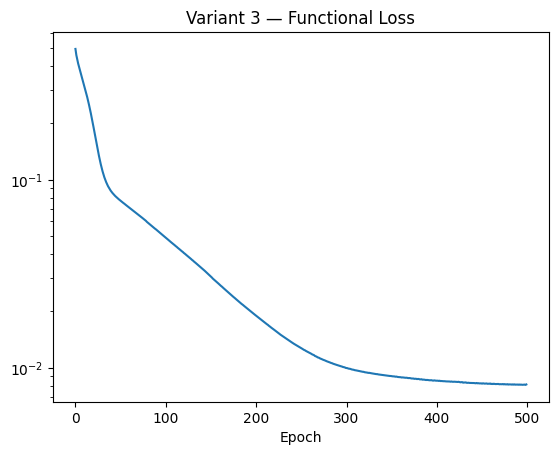

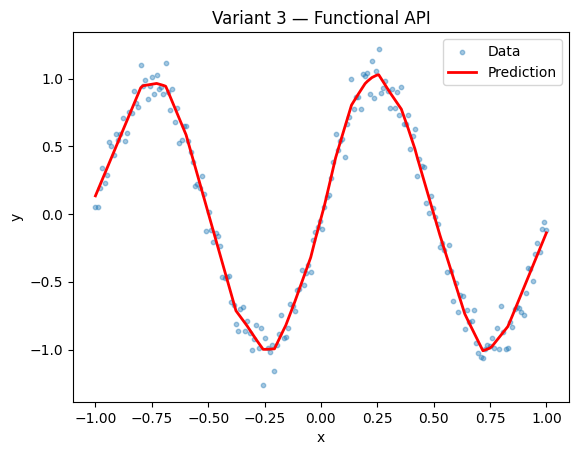

In [5]:
inputs = tf.keras.Input(shape=(1,), name='input')
h1     = tf.keras.layers.Dense(64, activation='relu', name='hidden1')(inputs)
h2     = tf.keras.layers.Dense(64, activation='relu', name='hidden2')(h1)
output = tf.keras.layers.Dense(1,                     name='output') (h2)

func_model = tf.keras.Model(inputs=inputs, outputs=output, name='functional_model')
func_model.summary()

func_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse'
)

history = func_model.fit(X, y, epochs=500, batch_size=32, verbose=0)
print(f'Final loss: {history.history["loss"][-1]:.6f}')

plt.plot(history.history['loss']); plt.yscale('log')
plt.title('Variant 3 — Functional Loss'); plt.xlabel('Epoch'); plt.show()

plot_fit(X, y, func_model.predict(X, verbose=0), 'Variant 3 — Functional API')

---
## Variant 4 — Subclassed Model (Keras Model class)
> Subclass `tf.keras.Model` and define `call()`.  
> Most flexible — mirrors PyTorch's `nn.Module` style.  
> Full control over the forward pass; custom training loops are easy to add.

Final loss (compile+fit): 0.008154


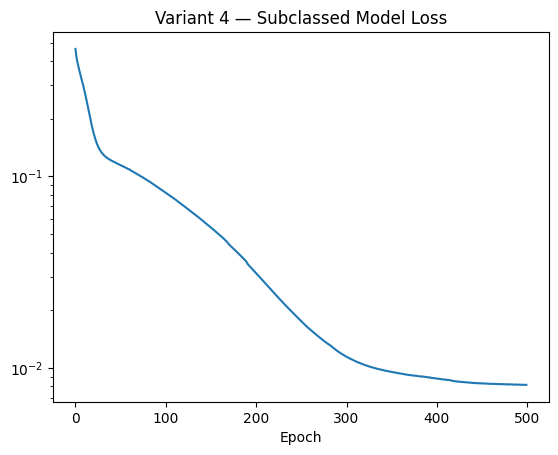

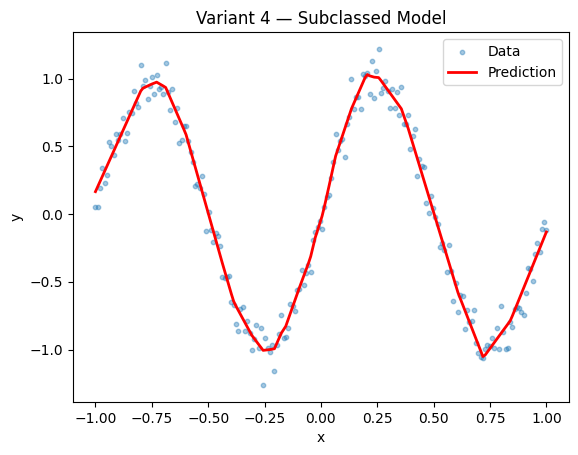

In [6]:
class RegressionNet(tf.keras.Model):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.fc1 = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.fc2 = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.fc3 = tf.keras.layers.Dense(1)   # output layer

    def call(self, x, training=False):
        x = self.fc1(x)
        x = self.fc2(x)
        return self.fc3(x)

sub_model = RegressionNet()

# ── Option A: use built-in compile + fit ──────────────────────────────────
sub_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='mse'
)

history = sub_model.fit(X, y, epochs=500, batch_size=32, verbose=0)
print(f'Final loss (compile+fit): {history.history["loss"][-1]:.6f}')

plt.plot(history.history['loss']); plt.yscale('log')
plt.title('Variant 4 — Subclassed Model Loss'); plt.xlabel('Epoch'); plt.show()

plot_fit(X, y, sub_model.predict(X, verbose=0), 'Variant 4 — Subclassed Model')

### Variant 4b — Subclassed Model with Custom `train_step`
> Override `train_step` inside the subclass for full control over the training loop  
> while still using `model.fit`. Best of both worlds.

Final loss (custom train_step): 0.007909


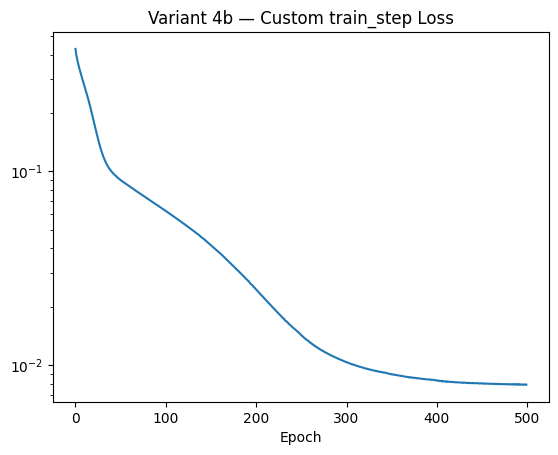

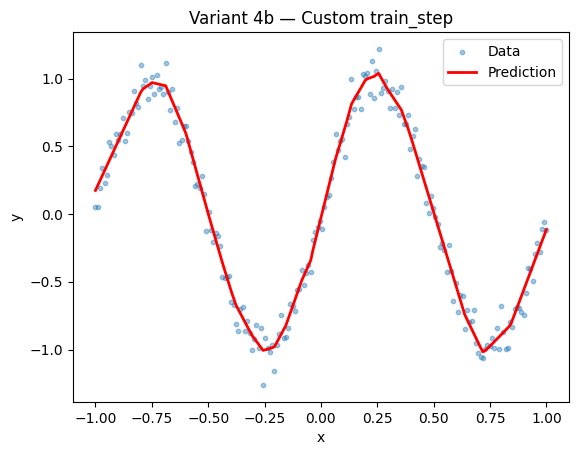

In [7]:
class RegressionNetCustomTrain(tf.keras.Model):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.fc1       = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.fc2       = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.fc3       = tf.keras.layers.Dense(1)
        self.loss_fn   = tf.keras.losses.MeanSquaredError()
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')

    def call(self, x, training=False):
        return self.fc3(self.fc2(self.fc1(x)))

    # ── custom training step ───────────────────────────────────────────────
    def train_step(self, data):
        x, y = data
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
            loss   = self.loss_fn(y, y_pred)

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {'loss': self.loss_tracker.result()}

    @property
    def metrics(self):
        return [self.loss_tracker]


custom_model = RegressionNetCustomTrain()
custom_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3))

history = custom_model.fit(X, y, epochs=500, batch_size=32, verbose=0)
print(f'Final loss (custom train_step): {history.history["loss"][-1]:.6f}')

plt.plot(history.history['loss']); plt.yscale('log')
plt.title('Variant 4b — Custom train_step Loss'); plt.xlabel('Epoch'); plt.show()

plot_fit(X, y, custom_model.predict(X, verbose=0), 'Variant 4b — Custom train_step')

---
## Summary Comparison

| Variant | Weights | Forward Pass | Backprop | Training Loop |
|---|---|---|---|---|
| **1. Low-Level** | `tf.Variable` manual | raw matmul + relu | `GradientTape` + manual `assign_sub` | manual `for` loop |
| **2. Sequential** | `Dense` layers | automatic | automatic | `model.fit` |
| **3. Functional** | `Dense` layers | layer graph | automatic | `model.fit` |
| **4. Subclassed** | `Dense` in `__init__` | `call()` method | automatic | `model.fit` |
| **4b. Custom train_step** | `Dense` in `__init__` | `call()` method | `GradientTape` in `train_step` | `model.fit` |